
# End-to-End AI Voice Assistance Pipeline

## Overview
This notebook implements an end-to-end AI-powered voice assistance pipeline. The primary goal is to convert voice inputs into actionable text commands, process these commands, and optionally generate voice responses. The pipeline is structured in multiple stages, each focusing on a critical part of the voice processing flow.

### Architecture
1. **Voice-to-Text Conversion**: Converts spoken language into text using a Speech-to-Text (STT) model.
2. **Command Processing**: Analyzes the text to determine the user's intent and generate appropriate responses or actions.
3. **Text-to-Speech (Optional)**: Converts the generated text responses back into speech to provide audio feedback to the user.

Each stage will be explained and documented thoroughly, along with the associated code implementation.



## Step 1: Voice-to-Text Conversion

### Overview:
In this step, we convert voice input (from a microphone or audio file) into text using a Speech-to-Text (STT) model. We utilize OpenAI's Whisper model, known for its low latency and high accuracy, making it ideal for real-time applications.

### Architecture Details:
1. **Model Selection**: We use OpenAI's Whisper model, particularly optimized for low-latency speech recognition.
   - **Model**: Whisper (from Whisper.cpp)
   - **Pre-trained Model**: English (en-US)

2. **Audio Preprocessing**:
   - **Sampling Rate**: 16 kHz (standard for high-quality STT)
   - **Audio Channel Count**: 1 (mono for simpler processing)
   
3. **Voice Activity Detection (VAD)**:
   - **VAD Threshold**: 0.5
   - **VAD Implementation**: Detects when the speaker is talking, ignoring silence to reduce unnecessary processing and latency.
   - **VAD Integration**: Implemented using an energy-based thresholding method that checks the energy level of the audio segments.



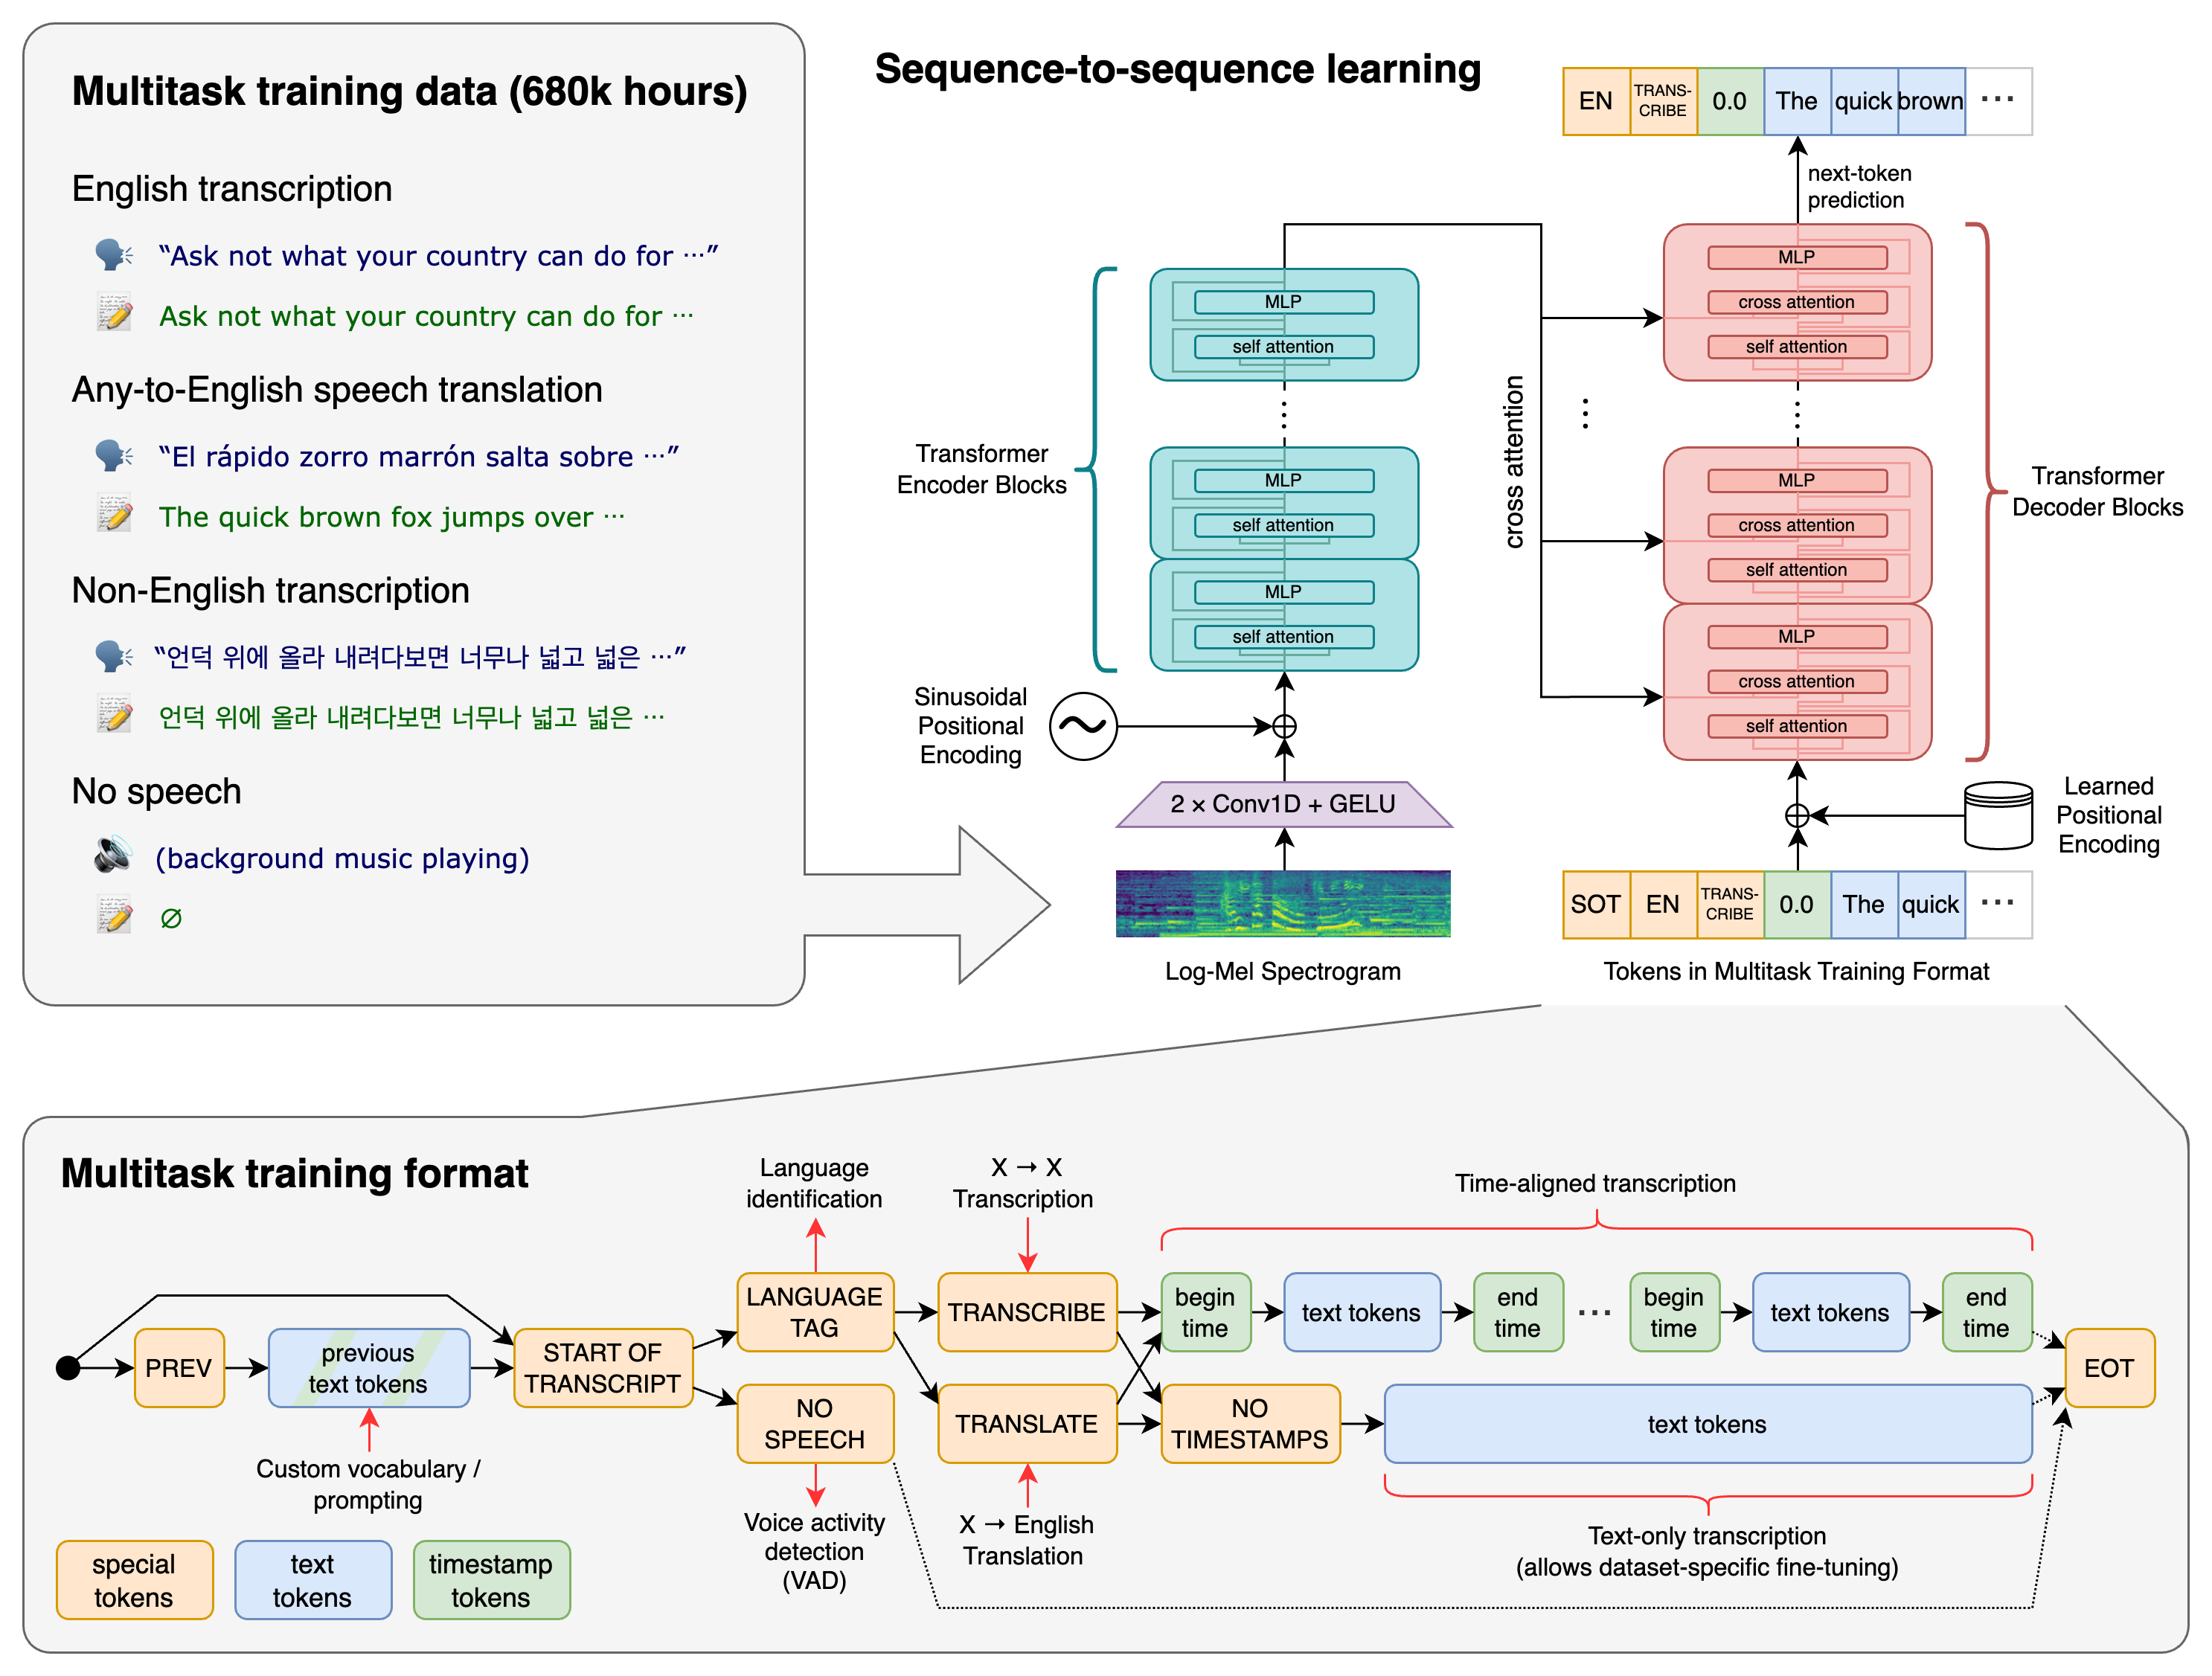

##Installing Required Dependencies
To implement the Voice-to-Text conversion and other steps in the AI Voice Assistance Pipeline, several Python packages are required. The following commands will install these dependencies:

* openai-whisper: This package is essential for using OpenAI's Whisper model, which is a high-performance Speech-to-Text (STT) system. Whisper is designed to provide accurate transcription with low latency, making it suitable for real-time applications.

* pydub: A powerful library used for audio processing. It provides simple and easy-to-use methods for manipulating audio files, such as cutting, concatenating, and applying various effects.

* webrtcvad: This library is used for Voice Activity Detection (VAD). VAD is crucial in speech processing pipelines as it helps identify when a person is speaking and when there is silence. This reduces unnecessary processing and enhances the efficiency of the system.

* gtts: Google Text-to-Speech (gTTS) is a library that allows you to convert text to speech. While optional, it can be used to generate spoken responses from text, which is useful for creating a conversational AI.





In [ ]:
!pip install openai-whisper
!pip install pydub openai-whisper webrtcvad
!pip install gtts

^C


##Generating Sample Audio
This code generates a sample audio file that will be used in the Voice-to-Text conversion step.

*   gTTS: Converts the given text to speech and saves it as an MP3 file.
*   pydub.AudioSegment: Converts the MP3 file to a WAV file with a 16 kHz
    sampling rate and mono channel, which is the required format for the Whisper model.



In [ ]:
from gtts import gTTS
from pydub import AudioSegment

# Define the text to be spoken
text = "What is the capital of France?"

# Generate the speech
tts = gTTS(text=text, lang='en')

# Save the speech to a WAV file
tts.save("input_audio.mp3")

# Convert the MP3 file to WAV with 16 kHz sampling rate and mono channel
audio = AudioSegment.from_mp3("input_audio.mp3")
audio = audio.set_frame_rate(16000).set_channels(1)
audio.export("input_audio.wav", format="wav")


<_io.BufferedRandom name='input_audio.wav'>

##Loading and Processing Audio
This code loads and ensures that the audio file is in the correct format for the Whisper model.

* Loading Audio: The WAV file is loaded into memory.
* Processing Audio: The audio is converted to a 16 kHz sampling rate and mono channel, which is required for accurate speech-to-text conversion.
Exporting Processed Audio: The processed audio is saved as a new WAV file

In [ ]:
from pydub import AudioSegment

# Load the audio file
audio = AudioSegment.from_file("input_audio.wav")

# Ensure 16 kHz sampling rate and mono channel
audio = audio.set_frame_rate(16000).set_channels(1)

# Export the processed audio
audio.export("processed_audio.wav", format="wav")


<_io.BufferedRandom name='processed_audio.wav'>

##Apply Voice Activity Detection (VAD)
This code applies Voice Activity Detection (VAD) to check if there is any speech in the audio file. It also ensures that the audio format meets the required specifications.

* Function read_wave: Reads the audio file and verifies it is in mono, 16-bit PCM format, and sampled at 16 kHz.
* Function apply_vad: Uses the WebRTC VAD library to determine if the audio contains speech. It processes the audio in frames and checks each frame for speech activity.
* VAD Application: The code checks if the file exists, then applies VAD to determine if there is speech in the audio file.

In [ ]:
import webrtcvad
import wave
import os

def read_wave(path):
    with wave.open(path, "rb") as wf:
        num_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()

        # Ensure the audio is mono, 16-bit PCM, and 16kHz
        assert num_channels == 1, "Audio must be mono"
        assert sample_width == 2, "Audio must be 16-bit PCM"
        assert sample_rate == 16000, "Sample rate must be 16000 Hz"

        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

def apply_vad(audio_path, vad_mode=3):
    vad = webrtcvad.Vad(vad_mode)
    pcm_data, sample_rate = read_wave(audio_path)
    frame_duration = 30  # duration of the frame in ms
    frame_size = int(sample_rate * frame_duration / 1000) * 2  # frame size in bytes
    is_speech = False

    for i in range(0, len(pcm_data), frame_size):
        frame = pcm_data[i:i + frame_size]
        if len(frame) < frame_size:
            break
        if vad.is_speech(frame, sample_rate):
            is_speech = True
            break

    return is_speech

# Process the input audio with VAD
audio_file = "processed_audio.wav"

# Check if the file exists before processing
if os.path.exists(audio_file):
    vad_result = apply_vad(audio_file, vad_mode=2)
    if vad_result:
        print("Voice detected, proceeding with transcription...")
    else:
        print("No voice detected, skipping transcription.")
else:
    print(f"File '{audio_file}' not found.")


Voice detected, proceeding with transcription...


##Load Whisper Model and Transcribe Audio
This code performs the following tasks:

* Load Whisper Model: It loads the pre-trained Whisper model with the base configuration. This model is used for automatic speech recognition (ASR) and is suitable for general transcription tasks.
* Transcribe Processed Audio: The transcribe method is called on the loaded model to process the audio file named processed_audio.wav. The language is set to English (en), and fp16=False ensures that full precision is used during the transcription.
* Extract and Print Transcribed Text: The transcribed text is extracted from the result dictionary and stored in the variable text_query. The final transcription is then printed to the console for review.

In [ ]:
import whisper

# Load the pre-trained Whisper model
model = whisper.load_model("base")

# Transcribe the processed audio
result = model.transcribe("processed_audio.wav", language="en", fp16=False)

# Extract the transcribed text
text_query = result["text"]

print("Transcribed Text:", text_query)


Transcribed Text:  What is the capital of France?


# Step 2: Text Input into LLM
In this step, we will input the transcribed text from Step 1 into a large language model (LLM) to generate a response. The process involves installing the necessary libraries, loading the GPT-2 model, and using it to generate text based on the provided input.Step 2: Text Input into LLM


This command installs the 'transformers' library, which provides tools for working with various pre-trained language models, including GPT-2.

In [ ]:
pip install transformers


##Load GPT-2 Model and Tokenizer

* Import Required Libraries: The GPT2LMHeadModel and GPT2Tokenizer classes are  imported from the transformers library. These classes are essential for working with the GPT-2 model.

* Load GPT-2 Model and Tokenizer:

* Model Name: The model_name variable is set to "gpt2", indicating the use of the base GPT-2 model.
* Tokenizer Initialization: The GPT2Tokenizer is loaded with the specified model_name. The tokenizer is responsible for converting text into a format that the GPT-2 model can process.
* Model Initialization: The GPT2LMHeadModel is loaded with the specified model_name. This model is used to generate text based on the input provided.
The tokenizer and model objects are now ready for use in text generation tasks.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


## Generate Text Based on Input


1. Set Input Text:


* input_text is assigned the value of text_query, which contains the transcribed text from Step 1. This text will be used as the input for the GPT-2 model.
2. Encode Input Text and Generate Response:

* Tokenization: The tokenizer.encode method converts the input_text into token IDs that the GPT-2 model can process. The return_tensors="pt" argument ensures the tokens are returned as PyTorch tensors.
* Text Generation: The model.generate method takes the tokenized input and generates a response. max_length=50 limits the length of the generated response to 50 tokens, and num_return_sequences=1 specifies that only one response should be generated.
3. Decode and Print Response:

* Decoding: The tokenizer.decode method converts the generated token IDs back into human-readable text. The skip_special_tokens=True argument ensures that special tokens used by the model are not included in the final output.
Output: The generated response is printed to the console for review.

In [ ]:
# Result text from Step 1 i.e "text_query"
input_text = text_query

# Encode the input text and generate a response
input_ids = tokenizer.encode(input_text, return_tensors="pt")
output = model.generate(input_ids, max_length=50, num_return_sequences=1)

# Decode the output and get the generated text
response_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Response:", response_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Response:  What is the capital of France?

The capital of France is Paris. It is the capital of France. It is the capital of France. It is the capital of France. It is the capital of France. It is the capital of France


#Step 3: Text-to-Speech Conversion
In this step, we will convert the text generated by the LLaMA model (from Step 2) into speech using the Edge TTS model. The process involves installing the required library, setting up the TTS model, and generating and saving the speech audio.



This command installs the 'edge-tts' library, which provides access to Microsoft's text-to-speech service.

In [ ]:
pip install edge-tts


## Convert Text to Speech Using Edge TTS
This code block converts text to speech using the Edge TTS library. The process includes defining an asynchronous function for text-to-speech conversion and calling this function with the generated text.

1. Define Asynchronous Text-to-Speech Function:

* text_to_speech Function: This function uses the Edge TTS library to convert text into speech. It takes the following parameters:
* text: The text to be converted into speech.
* output_file: The name of the file where the generated audio will be saved (default is "output.mp3").
* voice: The voice model to be used for speech synthesis (default is "en-US-JennyNeural").
* rate: The speech rate adjustment (default is "+0%").
* pitch: The pitch adjustment for the speech (default is "+0Hz").
await communicate.save(output_file): Asynchronously saves the generated speech to the specified audio file.
2. Set Text and Generate Speech:

* text: Assigns the text from response_text (generated in Step 2) to be converted.
* await text_to_speech(text): Calls the text_to_speech function to generate and save the speech audio file.

In [ ]:
import edge_tts

async def text_to_speech(text, output_file="output.mp3", voice="en-US-JennyNeural", rate="+0%", pitch="+0Hz"):
    communicate = edge_tts.Communicate(text=text, voice=voice, rate=rate, pitch=pitch)
    await communicate.save(output_file)

text = response_text
await text_to_speech(text)
